In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import classification_report

In [4]:
!ls

anomaly_detection.ipynb
baseline.ipynb
submission.csv
test.csv
train.csv
venv
Пояснение к датасету.docx


In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
sample_submission = pd.read_csv('submission.csv')

In [8]:
TYPE_DICT = {'Запрос': 0, 'Инцидент': 1}

In [9]:
def preprocess(df, is_train=True):
    df = df.copy()
    
    df['Дата закрытия обращения'] = pd.to_datetime(df['Дата закрытия обращения'])
    df['Дата обращения'] = pd.to_datetime(df['Дата обращения'])

    df['open_date'] = df['Дата обращения'].dt.date
    df['close_date'] = df['Дата закрытия обращения'].dt.date
    
    if is_train:
        df['Тип обращения итоговый'] = df['Тип обращения итоговый'].map(TYPE_DICT)
    
    return df

In [10]:
train = preprocess(train)
test = preprocess(test, False)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(train, train['Тип обращения итоговый'])

# Начнем с базовой модельки без учета времени

In [12]:
tf_idf = TfidfVectorizer(analyzer='char', ngram_range=(3,6), max_features=5000)
logreg = LogisticRegression(C=10**4, max_iter=500)

In [13]:
tf_idf.fit(X_train['Содержание'].fillna('NO DATA').str.replace('\*', ''))
logreg.fit(tf_idf.transform(X_train['Содержание'].fillna('NO DATA')), y_train)

print(classification_report(y_test, 
                            (logreg.predict_proba(tf_idf.transform(
                                X_test['Содержание'].fillna('NO DATA').str.replace('\*', '')))[:, 1] > 0.35).astype(int)))

/Users/dmitry/Dev/train_dataset_ЦБ/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3575
           1       0.77      0.63      0.70       126

    accuracy                           0.98      3701
   macro avg       0.88      0.81      0.84      3701
weighted avg       0.98      0.98      0.98      3701



In [15]:
tf_idf = TfidfVectorizer(analyzer='char', ngram_range=(3,6), max_features=5000)
logreg = LogisticRegression(C=10**3, max_iter=500)

In [16]:
tf_idf.fit(X_train['Содержание'].fillna('NO DATA').str.replace('\*', ''))
logreg.fit(tf_idf.transform(X_train['Содержание'].fillna('NO DATA')), X_train['Тип переклассификации'])

print(classification_report(X_test['Тип переклассификации'], 
                            logreg.predict(tf_idf.transform(X_test['Содержание'].fillna('NO DATA').str.replace('\*', '')))))

/Users/dmitry/Dev/train_dataset_ЦБ/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3611
           1       0.84      0.51      0.64        41
           2       0.67      0.57      0.62        49

    accuracy                           0.98      3701
   macro avg       0.83      0.69      0.75      3701
weighted avg       0.98      0.98      0.98      3701



# Учтем время

In [17]:
train['Дата обращения'].min(), train['Дата обращения'].max()

(Timestamp('2018-01-19 09:27:00'), Timestamp('2018-02-16 13:10:00'))

In [18]:
X_train, X_test = (train[train['Дата обращения'] < pd.to_datetime('2018-02-01 00:00:00')], 
                  train[train['Дата обращения'] >= pd.to_datetime('2018-02-01 00:00:00')])

In [19]:
tf_idf = TfidfVectorizer(analyzer='char', ngram_range=(3,6), max_features=5000)
logreg = LogisticRegression(C=10**4, max_iter=500)

In [20]:
tf_idf.fit(X_train['Содержание'].fillna('NO DATA').str.replace('\*', ''))
logreg.fit(tf_idf.transform(X_train['Содержание'].fillna('NO DATA')), X_train['Тип обращения итоговый'])

print(classification_report(X_test['Тип обращения итоговый'], 
                            (logreg.predict_proba(tf_idf.transform(
                                X_test['Содержание'].fillna('NO DATA').str.replace('\*', '')))[:, 1] > 0.35).astype(int)))

/Users/dmitry/Dev/train_dataset_ЦБ/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10546
           1       0.39      0.50      0.44       305

    accuracy                           0.96     10851
   macro avg       0.69      0.74      0.71     10851
weighted avg       0.97      0.96      0.97     10851



In [21]:
X_test['prob'] = logreg.predict_proba(tf_idf.transform(
                                X_test['Содержание'].fillna('NO DATA').str.replace('\*', '')))[:, 1]

/var/folders/9g/wztsgzvn6pb5m65md8hxmdrc0000gp/T/ipykernel_61841/2302636875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['prob'] = logreg.predict_proba(tf_idf.transform(


In [22]:
X_test['start_date_round'] = X_test['Дата обращения'].dt.round("3H")

/var/folders/9g/wztsgzvn6pb5m65md8hxmdrc0000gp/T/ipykernel_61841/1437121042.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['start_date_round'] = X_test['Дата обращения'].dt.round("3H")


In [30]:
X_test

,Содержание,Сервис,Приоритет,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,Решение,...,Дата восстановления,Дата закрытия обращения,Критичность,Влияние,Система,Место,open_date,close_date,prob,start_date_round
3952,<Бот-наблюдения> Система91. Ухудшение статуса ...,Сервис132,2-Средний,Закрыт,ФГ4,2018-02-01 08:00,2018-02-01 00:00:00,Инцидент,1,"Зависла, перезагрузка средсвами гипервизора",...,2018-02-01 00:55,2018-02-08 07:55:00,1-Особая,3-Малое,Система91,Место1,2018-02-01,2018-02-08,9.997264e-01,2018-02-01 00:00:00
3953,<Бот-наблюдения> Система91. Ухудшение статуса ...,Сервис132,2-Средний,Закрыт,ФГ128,2018-02-01 08:05,2018-02-01 00:05:00,Инцидент,1,Самовосстановление.,...,2018-02-01 06:36,2018-02-08 07:55:00,1-Особая,3-Малое,Система91,Место1,2018-02-01,2018-02-08,9.997264e-01,2018-02-01 00:00:00
3954,"Заявка № ***********, *******************",Сервис158,3-Низкий,Закрыт,ФГ381,2018-02-04 06:36,2018-02-01 00:07:00,Запрос,0,КПУ настроен согласно заявки,...,2018-02-01 01:53,2018-02-08 07:55:00,4-Нет,4-Нет влияния,Система164,Место185,2018-02-01,2018-02-08,1.687534e-04,2018-02-01 00:00:00
3955,Заявка на предоставление и отзыв прав доступа ...,Сервис22,3-Низкий,Закрыт,ФГ13,2018-02-03 02:36,2018-02-01 00:09:00,Запрос,0,Работы по обращению выполнены,...,2018-02-01 10:41,2018-02-08 11:59:00,2-Повышенная,4-Нет влияния,Система101,Место159,2018-02-01,2018-02-08,1.728703e-11,2018-02-01 00:00:00
3956,Нет возможности работать в Система500,Сервис152,3-Низкий,Закрыт,ФГ316,2018-02-02 00:23,2018-02-01 00:23:00,Запрос,1,Сервис успешно функционирует после сбоя,...,2018-02-01 02:00,2018-02-01 02:24:00,1-Особая,4-Нет влияния,Система159,Место177,2018-02-01,2018-02-01,9.946524e-01,2018-02-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14798,разблокировка учетной записи пользователя вСе...,Сервис7,2-Средний,Закрыт,ФГ8,2018-02-21 14:17,2018-02-16 13:02:00,Запрос,0,Личность пользователя идентифицирована\nПричи...,...,2018-02-16 13:02,2018-02-23 14:18:00,1-Особая,3-Малое,Система7,Место50,2018-02-16,2018-02-23,4.351663e-06,2018-02-16 12:00:00
14799,Устранение уязвимостей ИБ в соответствии с Пла...,АРМ,3-Низкий,Закрыт,ФГ135,2018-02-21 14:36,2018-02-16 13:07:00,Запрос,0,Выполнено,...,2018-02-21 12:03,2018-03-07 13:22:00,4-Нет,3-Малое,База,Место3,2018-02-16,2018-03-07,1.833566e-04,2018-02-16 12:00:00
14800,Контроль ПУ. Заявка на доступ к портам.,Сервис2,3-Низкий,Закрыт,ФГ315,2018-02-21 14:23,2018-02-16 13:08:00,Запрос,0,Работы выполнены согласно заявке.,...,2018-02-21 07:01,2018-03-07 08:46:00,4-Нет,4-Нет влияния,Система2,Место163,2018-02-16,2018-03-07,2.431344e-08,2018-02-16 12:00:00
14801,Ремонт стульев.,Сервис73,3-Низкий,Закрыт,ФГ159,2018-02-21 14:24,2018-02-16 13:09:00,Запрос,0,выполнено,...,2018-02-17 10:01,2018-02-24 11:22:00,4-Нет,4-Нет влияния,Система71,Место3,2018-02-16,2018-02-24,4.622684e-06,2018-02-16 12:00:00


хз, что отсюда выбирать, можно по-разному на это смотреть

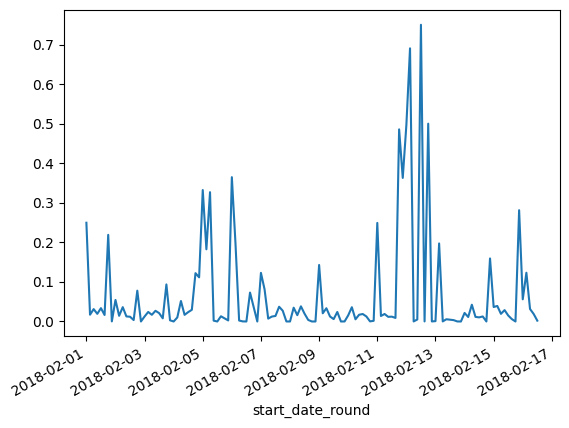

In [26]:
X_test.groupby(by='start_date_round')['prob'].mean().plot();

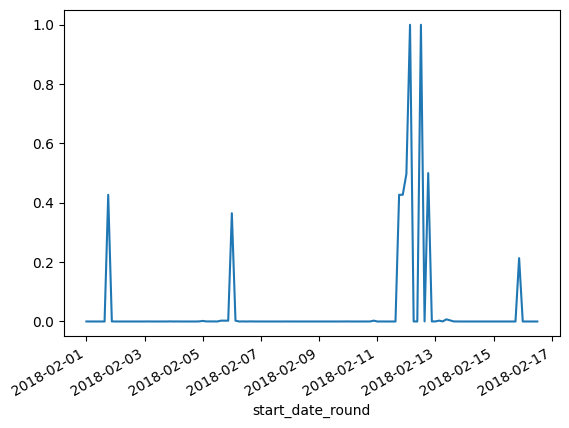

In [27]:
X_test.groupby(by='start_date_round')['prob'].median().plot();

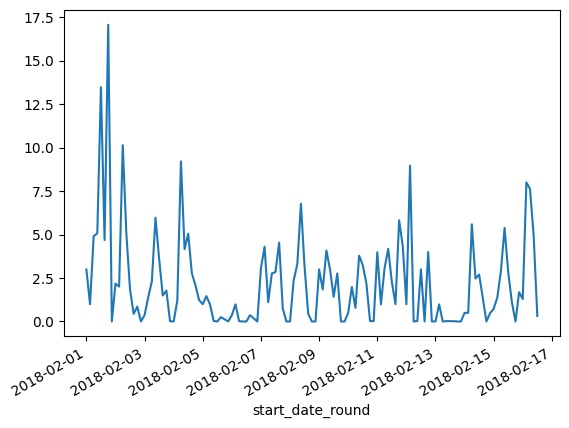

In [29]:
X_test.groupby(by='start_date_round')['prob'].sum().plot();

# Кластеризация

In [178]:
tf_idf = TfidfVectorizer(analyzer='word', max_features=5000)

In [179]:
cluster_inerias = []
train_data = tf_idf.fit_transform(train['Содержание'].fillna('NO DATA').str.replace('\*', ''))

for n in range(2, 30):
    mb_kmeans = MiniBatchKMeans(n_clusters=n)
    mb_kmeans.fit(train_data)
    cluster_inerias.append(mb_kmeans.inertia_)

/Users/dmitry/Dev/train_dataset_ЦБ/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


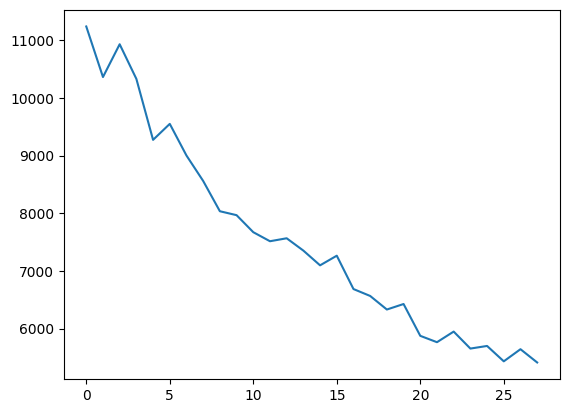

In [180]:
plt.plot(cluster_inerias)

In [181]:
mb_kmeans = MiniBatchKMeans(n_clusters=10)

train['cluster'] = mb_kmeans.fit_predict(train_data)

In [182]:
train['cluster'].value_counts()

cluster
3    5940
1    3140
2    1217
5    1080
6    1025
0     612
8     580
4     571
9     391
7     247
Name: count, dtype: int64

In [183]:
train.groupby(['cluster'])['Тип обращения итоговый'].mean()

cluster
0    0.000000
1    0.000000
2    0.000000
3    0.046801
4    0.000000
5    0.000926
6    0.000976
7    0.000000
8    0.000000
9    0.319693
Name: Тип обращения итоговый, dtype: float64

Cluster 0:


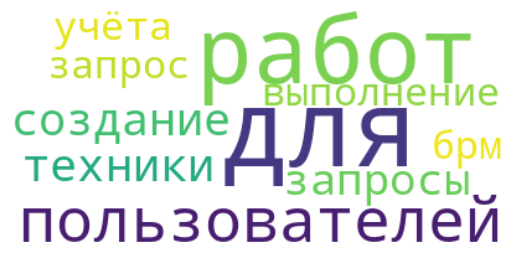

Cluster 1:


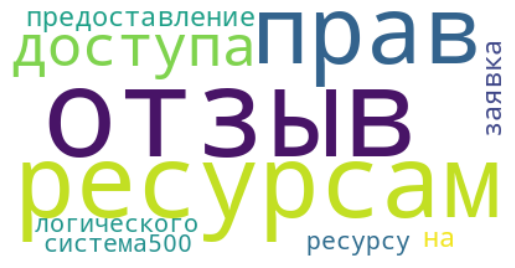

Cluster 2:


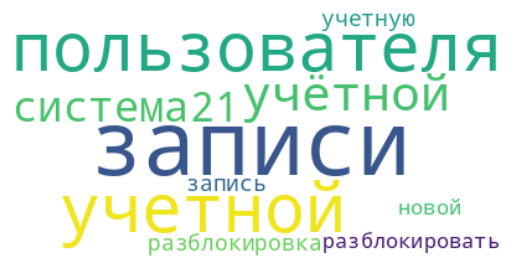

Cluster 3:


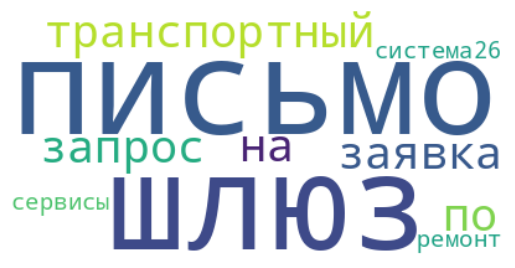

Cluster 4:


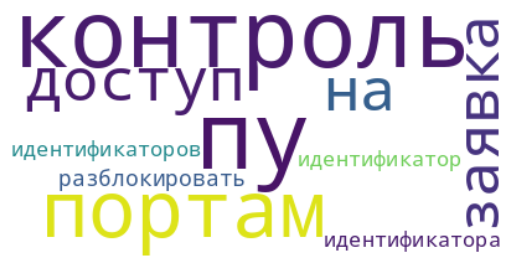

Cluster 5:


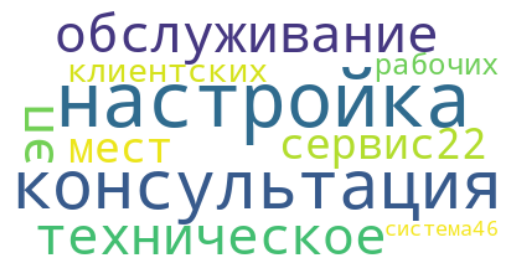

Cluster 6:


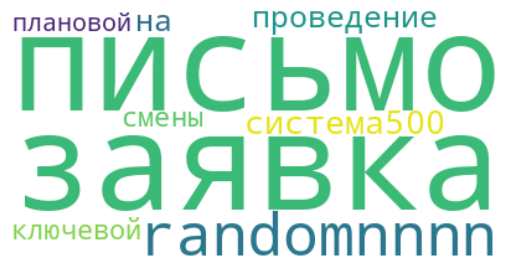

Cluster 7:


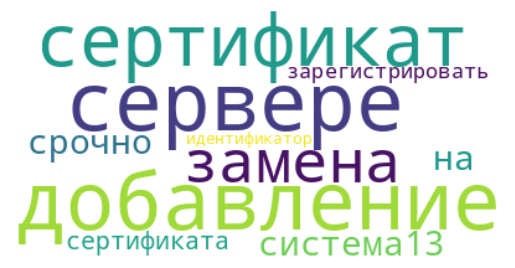

Cluster 8:


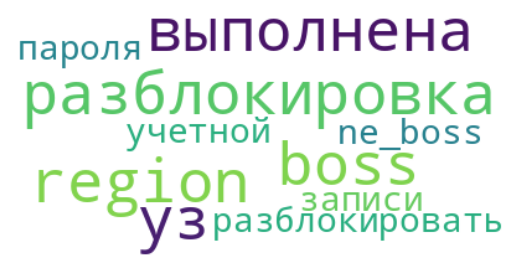

Cluster 9:


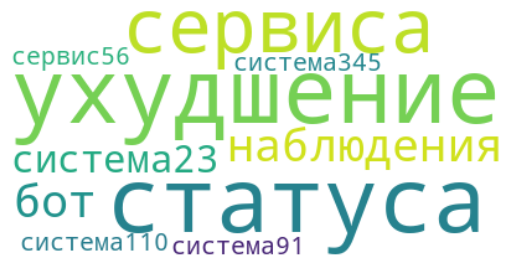

In [184]:
from wordcloud import WordCloud
order_centroids = mb_kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tf_idf.get_feature_names_out()

# Generate word cloud for each cluster
for i in range(10):
    print(f"Cluster {i}:")
    words = [terms[ind] for ind in order_centroids[i, :10]] # get top 10 features for each cluster
    wc = WordCloud(background_color="white", max_words=10).generate(" ".join(words))

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [175]:
train[train['cluster'] == 7][:10]

,Содержание,Сервис,Приоритет,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,Решение,...,Дата закрытия обращения,Критичность,Влияние,Система,Место,open_date,close_date,cluster,prob,start_date_round
12,Запрос на изменение учетной записи Система21,Сервис21,2-Средний,Отменен,ФГ360,2018-01-31 07:51,2018-01-25 23:49:00,Запрос,0,Запрос отменён пользователем из портала самооб...,...,NaT,1-Особая,3-Малое,Система21,Место197,2018-01-25,NaT,7,7.276296e-13,2018-01-26 00:00:00
55,Необходимо предоставить доступ учетной записи ...,АРМ,3-Низкий,Закрыт,ФГ343,2018-01-31 07:51,2018-01-26 03:34:00,Запрос,0,Исполнено,...,2018-02-02 07:52:00,4-Нет,4-Нет влияния,База,Место172,2018-01-26,2018-02-02,7,8.928439e-11,2018-01-26 03:00:00
107,Необходимо предоставить доступ учетной записи ...,АРМ,3-Низкий,Закрыт,ФГ343,2018-01-31 07:51,2018-01-26 05:42:00,Запрос,0,Доступ предоставлен,...,2018-02-02 10:38:00,4-Нет,4-Нет влияния,База,Место172,2018-01-26,2018-02-02,7,8.928439e-11,2018-01-26 06:00:00
115,(А) Отключение учетной записи,Сервис92,2-Средний,Закрыт,ФГ593,2018-01-31 07:51,2018-01-26 05:57:00,Запрос,0,Добрый день. Пользователь удален.,...,2018-02-07 07:38:00,1-Особая,4-Нет влияния,Система33,Место92,2018-01-26,2018-02-07,7,1.027178e-06,2018-01-26 06:00:00
146,Разблокировка учетной записи пользователя в Си...,Сервис7,2-Средний,Закрыт,ФГ8,2018-01-31 07:54,2018-01-26 06:39:00,Запрос,0,Выполнена разблокировка учетной записи Ne_bos...,...,2018-01-26 07:29:00,1-Особая,3-Малое,Система7,Место38,2018-01-26,2018-01-26,7,4.128758e-11,2018-01-26 06:00:00
150,Создание запроса,АРМ,3-Низкий,Закрыт,ФГ89,2018-01-31 07:56,2018-01-26 06:41:00,Запрос,0,выполнил настройку. вынес ярлыки на рабочий стол,...,2018-02-02 10:31:00,4-Нет,4-Нет влияния,База,Место59,2018-01-26,2018-02-02,7,5.119376e-05,2018-01-26 06:00:00
154,Разблокировка учетной записи пользователя в Си...,Сервис7,2-Средний,Закрыт,ФГ8,2018-01-31 07:59,2018-01-26 06:44:00,Запрос,0,Выполнена разблокировка учетной записи Ne_bos...,...,2018-02-02 08:24:00,1-Особая,3-Малое,Система7,Место51,2018-01-26,2018-02-02,7,4.128758e-11,2018-01-26 06:00:00
155,разблокировка учетной записи пользователя вСе...,Сервис7,2-Средний,Закрыт,ФГ8,2018-01-31 08:00,2018-01-26 06:45:00,Запрос,0,Личность пользователя идентифицирована\nПричи...,...,2018-02-02 08:24:00,1-Особая,3-Малое,Система7,Место24,2018-01-26,2018-02-02,7,1.539394e-07,2018-01-26 06:00:00
167,Создание Запрос для пользователей,Сервис8,3-Низкий,Закрыт,ФГ129,2018-01-31 08:08,2018-01-26 06:53:00,Запрос,0,выполнено,...,2018-02-02 08:37:00,2-Повышенная,3-Малое,База,Место83,2018-01-26,2018-02-02,7,2.188357e-05,2018-01-26 06:00:00
170,Создание Запрос для пользователей,Сервис8,3-Низкий,Закрыт,ФГ129,2018-01-31 08:09,2018-01-26 06:54:00,Запрос,0,выполнено,...,2018-02-02 08:37:00,2-Повышенная,3-Малое,База,Место83,2018-01-26,2018-02-02,7,2.188357e-05,2018-01-26 06:00:00


## Видим, что у нас реально есть кластера, на которые важнее обращать внимание при оценке инцидентов

Нужен wordcloud для важных кластеров

# Итоговое обучение модели


In [ ]:
tf_idf = TfidfVectorizer(analyzer='char', ngram_range=(3,6), max_features=5000)
logreg_obrasheniya = LogisticRegression(C=10**4, max_iter=500)
logreg_pereclassification = LogisticRegression(C=10**4, max_iter=500)

tf_idf.fit(train['Содержание'].fillna('NO DATA').str.replace('\*', ''))

logreg_obrasheniya.fit(tf_idf.transform(train['Содержание'].fillna('NO DATA')), train['Тип обращения итоговый'])
logreg_pereclassification.fit(tf_idf.transform(train['Содержание'].fillna('NO DATA')), train['Тип переклассификации'])


preds_pereclassification = logreg_pereclassification.predict(tf_idf.transform(test['Содержание'].fillna('NO DATA').str.replace('\*', '')))

preds_obrasheniya = (logreg_obrasheniya.predict_proba(tf_idf.transform(
                                test['Содержание'].fillna('NO DATA').str.replace('\*', '')))[:, 1] > 0.35).astype(int)

In [53]:
preds_pereclassification

array([0, 0, 0, ..., 0, 0, 0])

In [62]:
preds_obrasheniya

array([0, 0, 0, ..., 0, 1, 0])

In [77]:
sample_submission["Тип переклассификации"] = preds_pereclassification
sample_submission["Тип обращения итоговый"] = preds_obrasheniya
sample_submission["Тип обращения итоговый"] = sample_submission["Тип обращения итоговый"].map(dict((v, k) for k, v in TYPE_DICT.items()))

In [83]:
train["Тип обращения итоговый"].value_counts(normalize=True)

Тип обращения итоговый
0    0.972641
1    0.027359
Name: proportion, dtype: float64

In [85]:
sample_submission["Тип обращения итоговый"].value_counts(normalize=True)

Тип обращения итоговый
Запрос      0.980927
Инцидент    0.019073
Name: proportion, dtype: float64

In [86]:
sample_submission["Тип переклассификации"].value_counts(normalize=True)

Тип переклассификации
0    0.980927
2    0.013871
1    0.005202
Name: proportion, dtype: float64

In [87]:
train["Тип переклассификации"].value_counts(normalize=True)

Тип переклассификации
0    0.975816
2    0.014727
1    0.009458
Name: proportion, dtype: float64

In [88]:
sample_submission.to_csv("final_submission.csv", index=None)

# Подсчет аномалий

In [89]:
train["prob"] = logreg_obrasheniya.predict_proba(tf_idf.transform(train['Содержание'].fillna('NO DATA').str.replace('\*', '')))[:, 1]
test["prob"] = logreg_obrasheniya.predict_proba(tf_idf.transform(test['Содержание'].fillna('NO DATA').str.replace('\*', '')))[:, 1]
train['start_date_round'] = train['Дата обращения'].dt.round("3H")
test["start_date_round"] = test['Дата обращения'].dt.round("3H")

In [125]:
median_absolute_deviation = lambda y: np.median(np.abs(y - np.median(y)))
def calculate_anomalies(ts, metric, factor, title="Аномалии", ylabel="Количество обращений"):
    
    df_ = ts.copy()
    df_rolling_stats = (
        df_[metric]
        .rolling(
            window=49,
            center=True,
            min_periods=2,
        )
        .agg({"rolling_mean": "mean", "rolling_std": "std"})
    )
    df_[["rolling_mean", "rolling_std"]] = df_rolling_stats

    df_["is_anomaly"] = np.abs(df_[metric] - df_["rolling_mean"]) > factor * df_["rolling_std"]
    df_["upper"] = df_["rolling_mean"] + factor * df_["rolling_std"]
    df_["lower"] = df_["rolling_mean"] - factor * df_["rolling_std"]
    _, ax = plt.subplots(figsize=[10, 5])
    df_.plot(y=[metric, "rolling_mean"], marker=".", ax=ax)
    df_.plot(
        y=["upper", "lower"], figsize=[10, 5], ax=ax, color="k", alpha=0.2, legend=None
    )
    if df_["is_anomaly"].any():
        df_[metric].loc[df_["is_anomaly"]].plot(
            marker="o", color="r", ax=ax, legend=None, linestyle=""
        )
        
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time")

    return df_[df_["is_anomaly"] == True].index


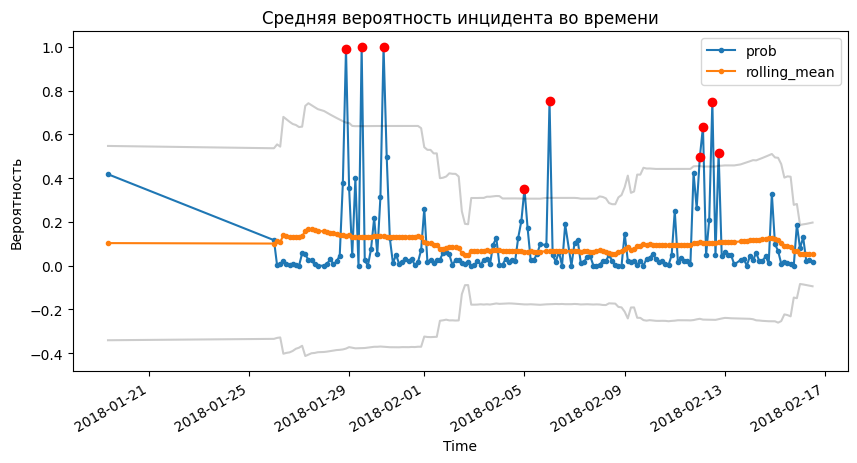

In [134]:
ts_train = train.groupby(by='start_date_round')['prob'].mean().to_frame()
anomaly_dates_probs_train = calculate_anomalies(ts_train, 
                    "prob", 
                    factor=2,
                    title="Средняя вероятность инцидента во времени",
                    ylabel="Вероятность");

# Можно посмотреть на конкретные даты

In [185]:
anomaly_dates_probs_train

DatetimeIndex(['2018-01-28 21:00:00', '2018-01-29 12:00:00',
               '2018-01-30 09:00:00', '2018-02-05 00:00:00',
               '2018-02-06 00:00:00', '2018-02-12 00:00:00',
               '2018-02-12 03:00:00', '2018-02-12 12:00:00',
               '2018-02-12 18:00:00'],
              dtype='datetime64[ns]', name='start_date_round', freq=None)

In [142]:
train[train["start_date_round"] == "2018-02-12 12:00:00"]

,Содержание,Сервис,Приоритет,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,Решение,...,Дата закрытия обращения,Критичность,Влияние,Система,Место,open_date,close_date,cluster,prob,start_date_round
12447,Система26,Сервис26,2-Средний,Закрыт,ФГ154,2018-02-17 06:36,2018-02-12 11:04:00,Запрос,0,"Добрый день. РК удалена, проект возвращён испо...",...,2018-02-21 07:51:00,1-Особая,3-Малое,Система26,Место97,2018-02-12,2018-02-21,0,7.804929e-14,2018-02-12 12:00:00
12448,<Бот-наблюдения> Система57 Система91. Ухудшени...,Сервис132,2-Средний,Закрыт,ФГ4,2018-02-12 20:44,2018-02-12 12:44:00,Инцидент,1,Выполняется штатная перезагрузка серверов сотр...,...,2018-02-21 07:51:00,1-Особая,3-Малое,Система91,Место1,2018-02-12,2018-02-21,7,1.000000e+00,2018-02-12 12:00:00
12449,<Бот-наблюдения> Система91. Ухудшение статуса ...,Сервис132,2-Средний,Закрыт,ФГ4,2018-02-12 20:46,2018-02-12 12:46:00,Инцидент,1,Выполняется штатная перезагрузка серверов сотр...,...,2018-02-21 07:51:00,1-Особая,3-Малое,Система91,Место1,2018-02-12,2018-02-21,7,9.999998e-01,2018-02-12 12:00:00
12450,<Бот-наблюдения> Система91. Ухудшение статуса ...,Сервис132,2-Средний,Закрыт,ФГ4,2018-02-12 20:46,2018-02-12 12:46:00,Инцидент,1,Выполняется штатная перезагрузка серверов сотр...,...,2018-02-21 07:51:00,1-Особая,3-Малое,Система91,Место1,2018-02-12,2018-02-21,7,9.999998e-01,2018-02-12 12:00:00


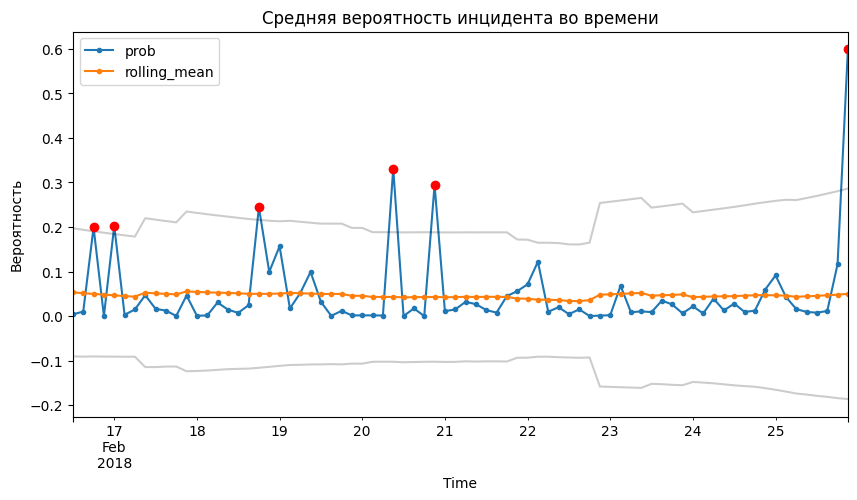

In [131]:
ts_test = test.groupby(by='start_date_round')['prob'].mean().to_frame()
anomaly_dates_probs_test = calculate_anomalies(ts_test, 
                    "prob", 
                    factor=2,
                    title="Средняя вероятность инцидента во времени",
                    ylabel="Вероятность");

In [137]:

anomaly_dates_probs_test

DatetimeIndex(['2018-02-16 18:00:00', '2018-02-17 00:00:00',
               '2018-02-18 18:00:00', '2018-02-20 09:00:00',
               '2018-02-20 21:00:00', '2018-02-25 21:00:00'],
              dtype='datetime64[ns]', name='start_date_round', freq=None)

In [154]:
test[test["start_date_round"] == "2018-02-20 09:00:00"]

,id,Содержание,Сервис,Приоритет,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,...,Дата восстановления,Дата закрытия обращения,Критичность,Влияние,Система,Место,open_date,close_date,prob,start_date_round
1940,16743,При выполнении Оператором НСИ пункта 8.3 Плана,Сервис240,3-Низкий,Закрыт,ФГ19,2018-02-23 08:36,2018-02-20 08:48:00,Инцидент,NaN,...,2018-02-20 10:12,2018-03-07 07:54:00,4-Нет,3-Малое,Система228,Место1,2018-02-20,2018-03-07,6.617320e-01,2018-02-20 09:00:00
1941,16744,Дистанционные курсы/тесты,Сервис36,3-Низкий,Отменен,ФГ47,2018-02-24 06:36,2018-02-20 09:48:00,Запрос,NaN,...,2018-02-20 11:54,NaT,4-Нет,4-Нет влияния,Система38,Место135,2018-02-20,NaT,3.391000e-08,2018-02-20 09:00:00
